## Additional Analysis of Captured Tweets

In [ ]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from os import listdir
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd
from mapboxgl.utils import *
from mapboxgl.viz import *
sns.set(style="ticks", color_codes=True)

tweets_data_path = r'C:\XXXXXXXXXX\Grey_Cup_Data.json'
file_name = r'C:\XXXXXXXXXX\Cleaned_Data.csv'

In [149]:
# Parse streaming tweet file
tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
        
tweets = pd.DataFrame()

tweet_text = []
tweet_lang = []
tweet_country = []
tweet_place = []
tweet_coords_x = []
tweet_coords_y = []

for tweet in tweets_data:
    tweet_text.append(tweet['text'])
    tweet_lang.append(tweet['lang'])
    if tweet['coordinates'] != None:
        tweet_coords_x.append(tweet['coordinates']['coordinates'][0])
        tweet_coords_y.append(tweet['coordinates']['coordinates'][1])
    else:
        tweet_coords_x.append(None)
        tweet_coords_y.append(None)
    if tweet['place'] != None:
        tweet_place.append(tweet['place']['name'])
        tweet_country.append(tweet['place']['country'])
    else:
        tweet_place.append(None)
        tweet_country.append(None)

In [150]:
# Create pandas dataframe using parsed tweet data
tweets = pd.DataFrame()
tweets['lang'] = tweet_lang
tweets['text'] = tweet_text
tweets['country'] = tweet_country
tweets['place'] = tweet_place
tweets['coords_x'] = tweet_coords_x
tweets['coords_y'] = tweet_coords_y

tweets.head()

,lang,text,country,place,coords_x,coords_y
0,en,When your dad scores @cfl team beer cozies and...,None,None,NaN,NaN
1,en,RT @calstampeders: Join us tonight at the Scot...,None,None,NaN,NaN
2,en,RT @Avry: NEW: Here's the full audio version o...,None,None,NaN,NaN
3,en,RT @CFL: The incredible @alessiacara performan...,None,None,NaN,NaN
4,en,RT @GreyCupFestival: When 🏈+🏒collide! Thanks f...,None,None,NaN,NaN


In [151]:
# Get data shape
np.shape(tweets_xy)

(169, 6)

In [152]:
# Map coordinate location data
df = tweets_xy[['coords_x','coords_y']]
data = df_to_geojson(df, lat='coords_y', lon='coords_x', precision=3)
token = "XXXXXXXXXX"
viz = CircleViz(data, access_token=token, center = (df.coords_x.mean(), df.coords_y.mean()),
                radius = 2, 
                zoom = 1,
                height = '400px',
                style="mapbox://styles/mapbox/dark-v9",
                label_color = 'red',
                color_default='#FFFF00')
viz.show()

In [153]:
# Describe the data
tweets.describe()

,coords_x,coords_y
count,169.000000,169.000000
mean,-110.011689,51.621682
std,10.434250,4.333719
min,-123.120400,23.268801
25%,-113.501600,51.045000
50%,-113.486073,53.541456
75%,-113.476133,53.559647
max,-73.944000,56.000000


In [154]:
# Print dataframe data types
tweets.dtypes

lang         object
text         object
country      object
place        object
coords_x    float64
coords_y    float64
dtype: object

In [155]:
# Remove hashtags and mentions
tweets['text'] = tweets['text'].apply(lambda x: re.sub(r'[@,#]+\w+', '', x))
# Remove retweets
tweets['text'] = tweets['text'].apply(lambda x: re.sub(r'RT', '', x))
# Remove urls
tweets['text'] = tweets['text'].apply(lambda x: re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', x))
# Convert to lower case
tweets['text'] = tweets['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# Remove numerals
tweets['text'] = tweets['text'].apply(lambda x: re.sub(r'\d','', x))
# Remove punctuation
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[^\w\s]','',x))
#Only include ASCII characters
tweets['text'] = tweets['text'].apply(lambda x: (x.encode('ascii',errors='ignore').decode()))
tweets = tweets[tweets['text']!='']
tweets = tweets[tweets['text']!=' ']
tweets.head()

,lang,text,country,place,coords_x,coords_y
0,en,when your dad scores team beer cozies and turn...,None,None,NaN,NaN
1,en,join us tonight at the scotiabank saddledome ...,None,None,NaN,NaN
2,en,new heres the full audio version of episode ...,None,None,NaN,NaN
3,en,the incredible performance at the halftime sh...,None,None,NaN,NaN
4,en,when collide thanks for offering our outoftow...,None,None,NaN,NaN


In [156]:
# Assign sentiment labels
def get_sentiment(x):
    blob = TextBlob(x)
    sent = blob.sentiment[0]
    if sent < 0:
        return 1
    elif sent == 0:
        return 0
    else:
        return 1
    
tweets['class'] = tweets['text'].apply(lambda x: get_sentiment(x))
tweets.head()

#Export to CSV
tweets.to_csv(file_name, sep=',')

In [157]:
Cleaned_TT = r'C:\XXXXXXXXXX\Cleaned_Data.csv'
df = pd.read_csv(Cleaned_TT)

In [158]:
# Separate tweets and sentiments into lists
train_list_1 = df['text'].tolist()
train_sentiment = df['class'].tolist()

In [159]:
# Tokenize words
train_list_2 = []
for i in train_list_1:
    tok = word_tokenize(str(i))
    train_list_2.append(tok)
# Remove stop words
stop = stopwords.words('english')
train_list_3 = []
for i in train_list_2:
    filtered_words = [word for word in i if word not in stop]
    train_list_3.append(filtered_words)
train_list_4 = []
# Apply least aggressive stemming method - Porter Stemmer
for i in train_list_3:
    port = PorterStemmer()
    stemmed_words = [port.stem(word) for word in i]
    train_list_4.append(stemmed_words)

In [160]:
# Create bag of words matrix
vectorizer = CountVectorizer()
train_list_4 = [' '.join(inner_list) for inner_list in train_list_4]
y = vectorizer.fit_transform(train_list_4)

In [ ]:
# Print word counts
freq_words = pd.DataFrame()
vocab = list(vectorizer.get_feature_names())
counts = y.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))
print(freq_distribution)
freq_words['word'] = vocab
freq_words['count'] = counts

In [162]:
# Create train/test split
count_vect_df = pd.DataFrame(y.todense(), columns=vectorizer.get_feature_names())
count_vect_lbl = pd.Series(train_sentiment)

X_train, X_test, y_train, y_test = train_test_split(count_vect_df, count_vect_lbl,
                                                    test_size=0.2, random_state=42)

# Train Gaussian and Multinomial Naive Bayes classifiers
clf_A = GaussianNB()
clf_B = MultinomialNB()

clf_A.fit(X_train, y_train)
y_pred_A = clf_A.predict(X_test)

clf_B.fit(X_train, y_train)
y_pred_B = clf_B.predict(X_test)

In [163]:
# Print classificaiton metrics
print(confusion_matrix(y_test, y_pred_A))  
print(classification_report(y_test, y_pred_A))
print(accuracy_score(y_test, y_pred_A))

print(confusion_matrix(y_test, y_pred_B))  
print(classification_report(y_test, y_pred_B))
print(accuracy_score(y_test, y_pred_B))

[[3304  109]
 [2928 3539]]
             precision    recall  f1-score   support

          0       0.53      0.97      0.69      3413
          1       0.97      0.55      0.70      6467

avg / total       0.82      0.69      0.69      9880

0.6926113360323887
[[2530  883]
 [ 249 6218]]
             precision    recall  f1-score   support

          0       0.91      0.74      0.82      3413
          1       0.88      0.96      0.92      6467

avg / total       0.89      0.89      0.88      9880

0.8854251012145749


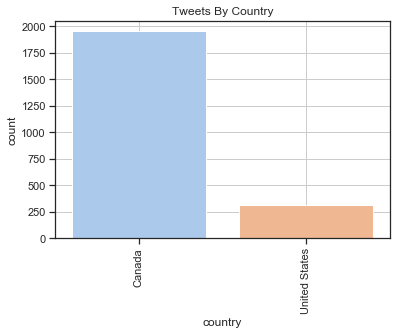

In [164]:
# Explore Data Using Seaborn: Countries
sns.set_palette("pastel")
ax = (sns.countplot(x="country", data=tweets, order=tweets.country.value_counts().iloc[:2].index))
#ax = (sns.countplot(x="country", data=tweets))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Tweets By Country")
ax.grid(b=True, which='major')
ax.grid(b=True, which='minor')

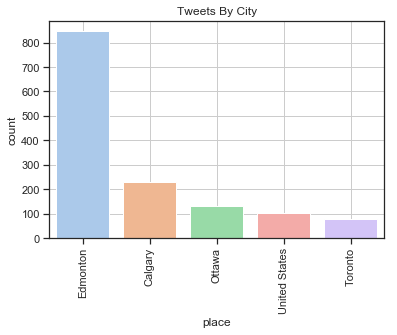

In [165]:
# Explore Data Using Seaborn: Cities
sns.set_palette("pastel")
ax = (sns.countplot(x="place", data=df, order=df.place.value_counts().iloc[:5].index))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Tweets By City")
ax.grid(b=True, which='major')
ax.grid(b=True, which='minor')

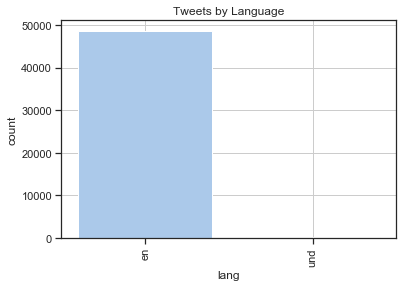

In [166]:
# Explore Data Using Seaborn: Languages
ax = (sns.countplot(x="lang", data=df, order=tweets.lang.value_counts().iloc[:2].index))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Tweets by Language")
ax.grid(b=True, which='major')
ax.grid(b=True, which='minor')

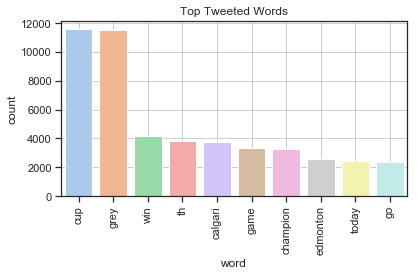

In [167]:
# Explore Data Using Seaborn: Top Words
freq_words_10 = freq_words.sort_values('count', ascending=False)
freq_words_10 = freq_words_10[0:10]
ax = sns.barplot(x="word", y="count", data=freq_words_10)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Top Tweeted Words")
ax.grid(b=True, which='major')
ax.grid(b=True, which='minor')
plt.tight_layout()
plt.show()

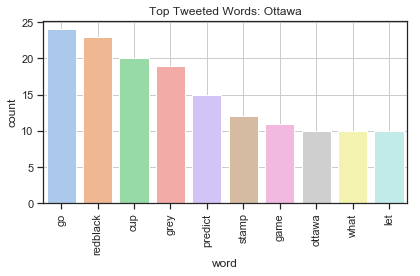

In [168]:
# Explore Top Words in Ottawa

df_ott = pd.read_csv(Cleaned_TT)
df_ott = df_ott[df_ott['place']=='Ottawa']

# Separate tweets and sentiments into lists
train_list_1 = df_ott['text'].tolist()
train_sentiment = df_ott['class'].tolist()

# Tokenize words
train_list_2 = []
for i in train_list_1:
    tok = word_tokenize(str(i))
    train_list_2.append(tok)
# Remove stop words
stop = stopwords.words('english')
train_list_3 = []
for i in train_list_2:
    filtered_words = [word for word in i if word not in stop]
    train_list_3.append(filtered_words)
train_list_4 = []
# Apply least aggressive stemming method - Porter Stemmer
for i in train_list_3:
    port = PorterStemmer()
    stemmed_words = [port.stem(word) for word in i]
    train_list_4.append(stemmed_words)
    
# Create bag of words matrix
vectorizer = CountVectorizer()
train_list_4 = [' '.join(inner_list) for inner_list in train_list_4]
y = vectorizer.fit_transform(train_list_4)

# Print word counts
freq_words = pd.DataFrame()
vocab = list(vectorizer.get_feature_names())
counts = y.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))
#print(freq_distribution)
freq_words['word'] = vocab
freq_words['count'] = counts

# Explore Data Using Seaborn: Top Words
freq_words_10 = freq_words.sort_values('count', ascending=False)
freq_words_10 = freq_words_10[0:10]
ax = sns.barplot(x="word", y="count", data=freq_words_10)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Top Tweeted Words: Ottawa")
ax.grid(b=True, which='major')
ax.grid(b=True, which='minor')
plt.tight_layout()
plt.show()

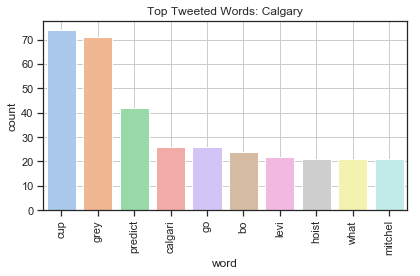

In [170]:
# Explore Top Words in Calgary

df_cal = pd.read_csv(Cleaned_TT)
df_cal = df_cal[df_cal['place']=='Calgary']

# Separate tweets and sentiments into lists
train_list_1 = df_cal['text'].tolist()
train_sentiment = df_cal['class'].tolist()

# Tokenize words
train_list_2 = []
for i in train_list_1:
    tok = word_tokenize(str(i))
    train_list_2.append(tok)
# Remove stop words
stop = stopwords.words('english')
train_list_3 = []
for i in train_list_2:
    filtered_words = [word for word in i if word not in stop]
    train_list_3.append(filtered_words)
train_list_4 = []
# Apply least aggressive stemming method - Porter Stemmer
for i in train_list_3:
    port = PorterStemmer()
    stemmed_words = [port.stem(word) for word in i]
    train_list_4.append(stemmed_words)
    
# Create bag of words matrix
vectorizer = CountVectorizer()
train_list_4 = [' '.join(inner_list) for inner_list in train_list_4]
y = vectorizer.fit_transform(train_list_4)

# Print word counts
freq_words = pd.DataFrame()
vocab = list(vectorizer.get_feature_names())
counts = y.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))
freq_words['word'] = vocab
freq_words['count'] = counts

# Explore Data Using Seaborn: Top Words
freq_words_10 = freq_words.sort_values('count', ascending=False)
freq_words_10 = freq_words_10[0:10]
ax = sns.barplot(x="word", y="count", data=freq_words_10)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Top Tweeted Words: Calgary")
ax.grid(b=True, which='major')
ax.grid(b=True, which='minor')
plt.tight_layout()
plt.show()